<a href="https://colab.research.google.com/github/SeohyunLee0321/GDSC/blob/main/%ED%98%BC%EA%B3%B5%EB%A8%B8%EC%8B%A0_Chapter8_2%2C_3_%ED%95%A9%EC%84%B1%EA%B3%B1%EC%8B%A0%EA%B2%BD%EB%A7%9D%EC%9D%84%EC%82%AC%EC%9A%A9%ED%95%9C%EC%9D%B4%EB%AF%B8%EC%A7%80%EB%B6%84%EB%A5%98%2C_%EC%8B%9C%EA%B0%81%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**패션 MNIST 데이터 불러오기**

In [ ]:
# 데이터 스케일을 0 ~ 255 사이에서 0 ~ 1 사이로 바꾸고 훈련 세트와 검증 세트로 나누기
# 합성곱 신경망은 2차원 이미지를 그대로 사용 -> 완전 연결 시경망에서처럼 일렬로 펼치지 않음
# 입력 이미지는 항상 깊이 (채널) 차원이 있어야 함
# 흑백 이미지의 경우 채널 차원이 없는 2차원 배열
# Conv2D 층을 사용하기 위해 마지막에 채널 차원을 추가해야 함
# 넘파이 reshpae() 메서드를 사용해 전체 배열 차원을 그대로 유지하면서 마지막에 차원 추가
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) =\
  keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size = 0.2, random_state = 42
)

4422102/4422102 [==============================] - 0s 0us/step


**합성곱 신경망 만들기**

In [ ]:
# 전형적인 합성곱 신경망의 구조는 합성곱 층으로 이미지에서 특징을 감지한 후 밀집층으로 클래스에 따른 분류 확률 계산
# 케라스의 Sequential 클래스를 사용해 순서대로 구조 정의
# Sequential 클래스 객체 만들고 첫 번째 합성곱 층인 Conv2D 추가
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size = 3, activation = 'relu',
                              padding = 'same', input_shape = (28, 28, 1)))

# 합성곱 층은 32개의 필터 사용, 커널의 크기는 (3, 3), 렐루 활성화 함수 와 세임 패딩을 사용

In [ ]:
# 폴링 층 추가
# 케라스는 최대 풀링과 평균 풀링을 MaxPooling2D 와 AveragePooling2D 클래스로 제공
# 전형적인 풀링 크기인 (2, 2) 풀링 사용
model.add(keras.layers.MaxPooling2D(2))

# (2, 2) 풀링을 적용했기 때문에 특성 맵의 크기는 절반으로 줄어듦
# 합성곱 층에서 32개의 필터를 사용했기 때문에 이 특성 맵의 깊이는 32
# 최대 풀링을 통과한 특성 맵의 크기는 (14, 14, 32)가 됨

In [ ]:
# 첫 번째 합성곱-풀링 층 다음에 두 번째 합성곱-풀링 층 추가
# 필터의 개수 64개로 늘림
model.add(keras.layers.Conv2D(64, kernel_size = 3, activation = 'relu', padding = 'same'))
model.add(keras.layers.MaxPooling2D(2))

# 이어지는 풀링 층에서 이 크기를 절반으로 줄임, 64개의 필터 사용 -> 특성 맵의 크기는 최종적으로 (7, 7, 64)

In [ ]:
# 3차원 특성 맵을 일렬로 펼치기
# 마지막에 10개의 뉴런을 가진 (밀집) 출력층에서 확률을 계산하기 때문
# 특성 맵을 일렬로 펼쳐서 바로 출력층에 전달하지 않고 중간에 하나의 밀집 은닉층을 하나 더 두기
# Flatten 클래스 -> Dense 은닉층 -> Dense 출력층
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation = 'relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation = 'softmax'))

# 은닉층과 출력층 사이에 드롭아웃 넣음 -> 드롭아웃 층이 과대적합을 막아 성능 개선

In [ ]:
# summary() 메서드로 모델 구조 출력
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

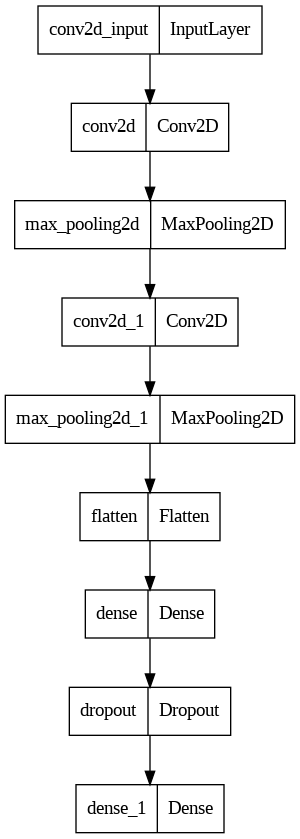

In [ ]:
# 층의 구성을 그림으로 표현
keras.utils.plot_model(model)

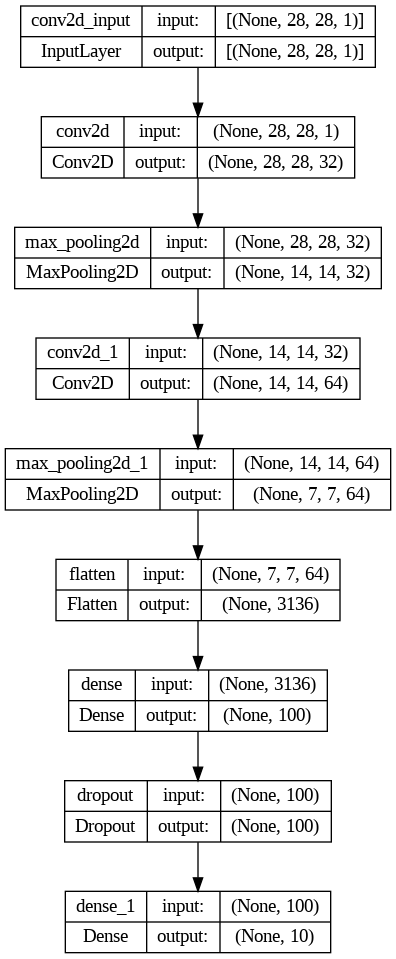

In [ ]:
# plot_model() 함수의 show_shapes 매개변수 True 로 설정하면 그림에 입출력 크기 표시
keras.utils.plot_model(model, show_shapes = True)

**모델 컴파일과 훈련**

In [ ]:
# Adam 옵티마이저 사용하고 ModelCheckpoint 콜백과 EarlyStopping 콜백을 함께 사용해 조기 종료 기법 구현
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True)
history = model.fit(train_scaled, train_target, epochs = 20,
                    validation_data = (val_scaled, val_target),
                    callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 18s 7ms/step - loss: 0.5268 - accuracy: 0.8098 - val_loss: 0.3441 - val_accuracy: 0.8746
Epoch 2/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3506 - accuracy: 0.8739 - val_loss: 0.2890 - val_accuracy: 0.8922
Epoch 3/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.3034 - accuracy: 0.8904 - val_loss: 0.2572 - val_accuracy: 0.9057
Epoch 4/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2702 - accuracy: 0.9015 - val_loss: 0.2447 - val_accuracy: 0.9115
Epoch 5/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2447 - accuracy: 0.9094 - val_loss: 0.2444 - val_accuracy: 0.9104
Epoch 6/20
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2241 - accuracy: 0.9160 - val_loss: 0.2288 - val_accuracy: 0.9138
Epoch 7/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2064 - accuracy: 0.9237 - val_loss: 0.2193 - val_accurac

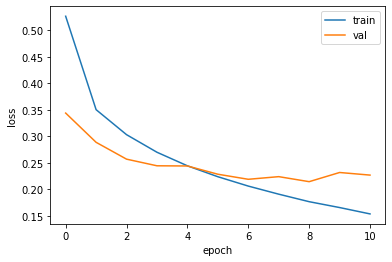

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
# EarlyStopping 클래스에서 restore_best_weights 매개변수를 True로 지정했으므로 현재 model 객체가 최적의 모델 파라미터로 복원되어 있음
# ModelCheckpoint 콜백이 저장한 best-cnn-model.h5 파일을 다시 읽을 필요가 없음
# 세트에 대한 성능 평가
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.2148 - accuracy: 0.9227


[0.21476420760154724, 0.9227499961853027]

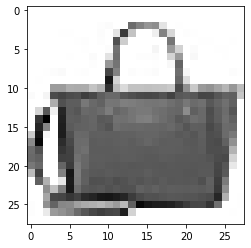

In [ ]:
# matplotlib 에서는 흑백 이미지에 깊이 차원이 없음
# (28, 28, 1) 크기를 (28, 28)로 바꾸어 출력해야 함
# 첫 번째 이미지 확인
plt.imshow(val_scaled[0].reshape(28, 28), cmap = 'gray_r')
plt.show()

In [ ]:
# 모델이 이 이미지에 대해 어떤 예측하는지 확인
preds = model.predict(val_scaled[0:1])
print(preds)

# predict() 메서드는 10개의 클래스에 대한 예측 확률 출력
# 9번째 값이 1, 다른 값은 거의 0에 가까움

1/1 [==============================] - 0s 129ms/step
[[1.6481167e-16 4.8898268e-25 4.4384506e-18 2.0355920e-19 1.9756380e-18
  4.9800884e-19 3.8532119e-16 1.4694471e-18 1.0000000e+00 4.8016132e-20]]


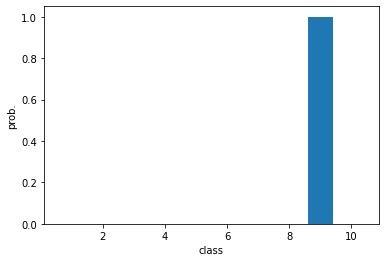

In [ ]:
# 그래프로 확인
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [ ]:
# 레이블 저장
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [ ]:
# preds 배열에서 가장 큰 인덱스를 찾아 classes 리스트의 인덱스로 사용
import numpy as np
print(classes[np.argmax(preds)])

가방


In [ ]:
# 모델을 실전에 투입했을 때 얻을 수 있는 예상 성능 측정
# 픽셀값의 범위를 0 ~ 1 사이로 바꾸고 이미지 크기를 (28, 28)에서 (28, 28, 1)로 바꾸기
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

In [ ]:
# evaluate() 메서드로 테스트 세트에 대한 성능 측정
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 1s 3ms/step - loss: 0.2292 - accuracy: 0.9204


[0.22923141717910767, 0.9204000234603882]

**가중치 시각화**

In [ ]:
from tensorflow import keras
model = keras.models.load_model('best-cnn-model.h5')

In [ ]:
model.layers

# Conv2D, MaxPooling2D 층이 번갈아 2번 연속 등장
# Flatten, Dense, Dropout 층이 차례대로 등장
# 마지막에 Dense 출력층

In [ ]:
# 첫 번째 합성곱 층의 가중치 조사
# 층의 가중치와 절편은 층의 weights 속성에 저장되어 있음
conv = model.layers[0]
print(conv.weights[0].shape, conv.weights[1].shape)

# 커널의 크기를 (3, 3)으로 지정함, 합성곱 층에 전달되는 입력의 깊이는 1 -> 실제 커널의 크기 (3, 3, 1)
# 필터 개수가 32개 -> weights의 첫번째 원소인 가중치의 크기는 (3, 3, 1, 32)
# weights 의 두 번째 원소는 절편의 개수, 필터마다 1개의 절편이 있기 때문에 (32,)

(3, 3, 1, 32) (32,)


In [ ]:
# weights 속성은 텐서플로우의 다차원 배열인 Tensor 클래스의 객체
# 다루기 쉽도록 numpy() 메서드를 사용해 넘파이 배열로 변환
# 가중치 배열의 평균과 표준편차를 넘파이 mean() 메서드와 std() 메서드로 계산
conv_weights = conv.weights[0].numpy()
print(conv_weights.mean(), conv_weights.std())

-0.034505818 0.26647252


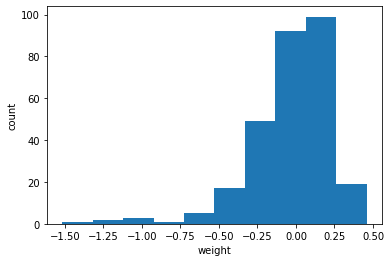

In [ ]:
# 훈련하기 전의 가중치와 비교
import matplotlib.pyplot as plt
plt.hist(conv_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

# matplotlib의 hist() 함수에는 히스토그램을 그리기 위해 1차원 배열로 전달해야 함
# reshape 메서드로 conv_weights 배열을 1개의 열이 있는 배열로 변환

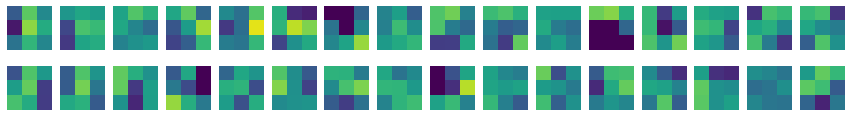

In [ ]:
# 32개의 커널을 16개씩 두 줄에 출력
# subplots() 함수를 사용해 32개의 그래프 영역을 만들고 커널을 출력
fig, axs = plt.subplots(2, 16, figsize = (15, 2))
for i in range(2):
  for j in range(16):
    axs[i, j].imshow(conv_weights[:, :, 0, i * 16 + j], vmin =- 0.5, vmax = 0.5)
    axs[i, j].axis('off')
plt.show()

In [ ]:
no_training_model = keras.Sequential()
no_training_model.add(keras.layers.Conv2D(32, kernel_size = 3, activation =\
                                          'relu', padding = 'same', input_shape = (28, 28, 1)))

In [ ]:
no_training_conv = no_training_model.layers[0]
print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


In [ ]:
no_training_weights = no_training_conv.weights[0].numpy()
print(no_training_weights.mean(), no_training_weights.std())

0.0097041465 0.08767151


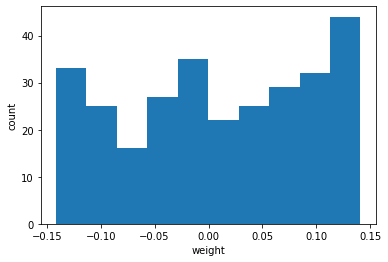

In [ ]:
plt.hist(no_training_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

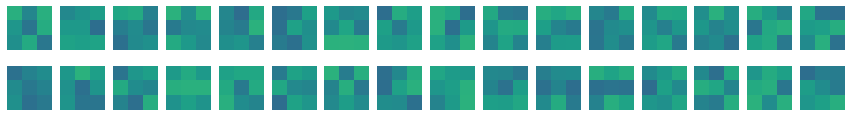

In [ ]:
fig, axs = plt.subplots(2, 16, figsize = (15, 2))
for i in range(2):
  for j in range(16):
    axs[i, j].imshow(no_training_weights[:, :, 0, i * 16 + j], vmin =- 0.5, vmax = 0.5)
    axs[i, j].axis('off')
plt.show()

**함수형 API**

In [ ]:
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='conv2d_input'), name='conv2d_input', description="created by layer 'conv2d_input'")


In [ ]:
conv_acti = keras.Model(model.input, model.layers[0].output)

**특성 맵 시각화**

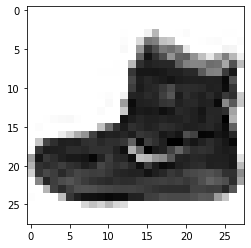

In [ ]:
(train_input, train_target), (test_input, test_target) =\
  keras.datasets.fashion_mnist.load_data()
plt.imshow(train_input[0], cmap = 'gray_r')
plt.show()

In [ ]:
inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv_acti.predict(inputs)

1/1 [==============================] - 0s 41ms/step


In [ ]:
print(feature_maps.shape)

(1, 28, 28, 32)


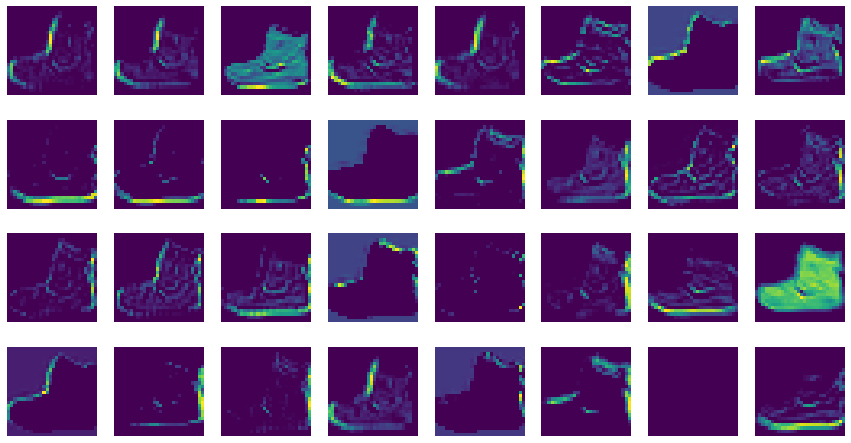

In [ ]:
fig, axs = plt.subplots(4, 8, figsize = (15, 8))
for i in range(4):
  for j in range(8):
    axs[i, j].imshow(feature_maps[0, :, :, i * 8 + j])
    axs[i, j].axis('off')
plt.show()

In [ ]:
conv2_acti = keras.Model(model.input, model.layers[2].output)

In [ ]:
inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv2_acti.predict(inputs)

1/1 [==============================] - 0s 48ms/step


In [ ]:
print(feature_maps.shape)

(1, 14, 14, 64)


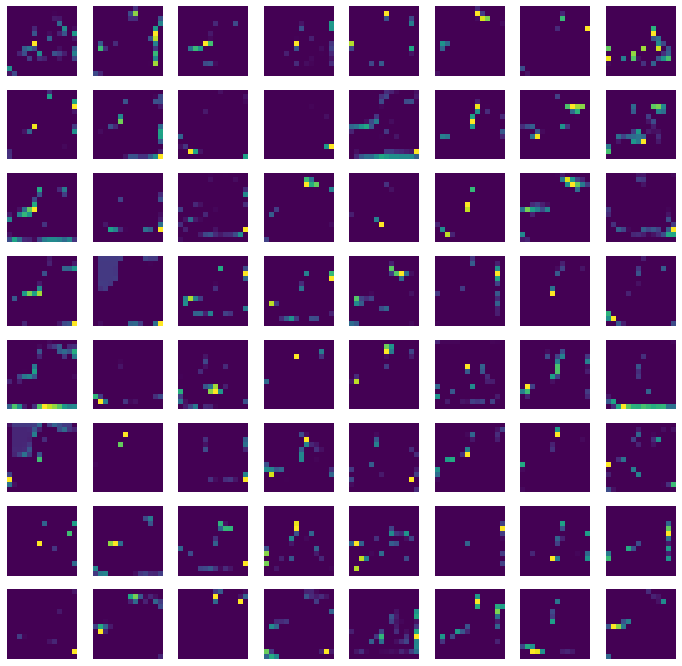

In [ ]:
fig, axs = plt.subplots(8, 8, figsize = (12, 12))
for i in range(8):
  for j in range(8):
    axs[i, j].imshow(feature_maps[0, :, :, i * 8 + j])
    axs[i, j].axis('off')
plt.show()